In [1]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from scipy import signal
import librosa
import IPython.display

Text(0.5, 1.0, 'Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)')

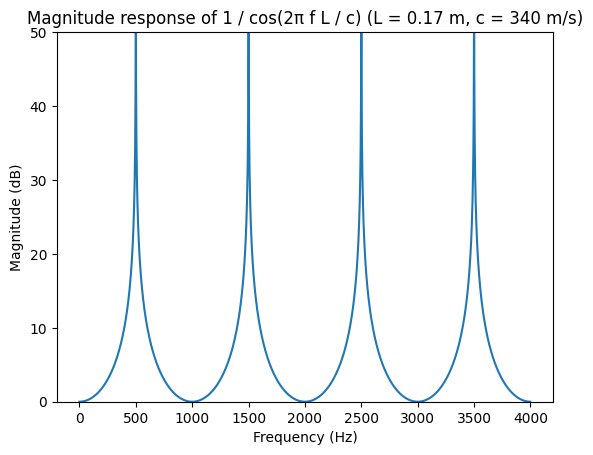

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 管の共鳴を簡易モデルで可視化するコード
#   |H(f)| = 1 / |cos(2π f L / c)|
#
# 想定している物理モデル：
#   - 長さ L の一様な音響管（声道や管楽器の非常に単純化したモデル）
#   - 音速 c [m/s]
#   - 周波数 f に対する伝達関数の大きさを
#       H(f) = 1 / cos(kL)   （k = 2π f / c）
#     という形で近似したもの（cos が 0 に近づく周波数で強い共鳴が出る）
# ============================================

# 音速 [m/s]
c = 340

# 管の長さ [m]
# 0.17 m ≒ 17 cm なので、人間の声道の平均的な長さを大まかに想定している値。
# この長さによって共鳴（フォルマント）周波数の位置が決まる。
length = 0.17

# サンプリングレート [Hz]
# ここでは 8 kHz を想定。周波数軸は 0〜fs/2（ナイキスト周波数）までを描画する。
fs = 8000

# 周波数軸 [Hz] の生成
# np.arange(0, fs/2) で 0,1,2,...,(fs/2 - 1) [Hz] を生成する。
# 離散的な周波数点で H(f) の値を計算し、周波数応答を可視化する。
frequency = np.arange(0, fs / 2)

# ============================================
# 伝達関数 H(f) = 1 / cos(2π f L / c) の大きさ |H(f)| を計算
# ============================================
# kL = 2π f L / c  は波数 k と管長 L の積に相当。
# cos(kL) が 0 に近づく周波数（共鳴周波数）で |H(f)| が非常に大きくなる。
#
# 共鳴周波数の条件：
#   cos(2π f L / c) = 0
#   ⇒ 2π f L / c = (2n+1) π/2   （n = 0,1,2,...）
#   ⇒ f = (2n+1) c / (4L)
# したがって、(2n+1) 次の奇数倍で共鳴ピークが現れる。
#
# np.abs(1/np.cos(...)) で振幅 |H(f)| を計算し、
# その後 20*log10 で dB スケールに変換してプロットする。
H_mag = np.abs(1 / np.cos(2 * np.pi * frequency * length / c))

# ============================================
# 周波数応答（振幅スペクトル）をプロット
# ============================================
plt.plot(frequency, 20 * np.log10(H_mag))

# y 軸を 0〜50 dB の範囲に制限
# 共鳴周波数付近では理論上振幅が無限大に発散するが、
# プロットとしては 0〜50 dB 程度に切ることで、
# 共鳴ピークの位置だけを見やすく表示している。
plt.ylim(0, 50)

# 軸ラベルなどを付けると、何を見ているかがより明確になる（任意）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude response of 1 / cos(2π f L / c) (L = 0.17 m, c = 340 m/s)")

# plt.show()  # スクリプトとして実行する場合は明示的に表示する

Text(0.5, 1.0, 'Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})')

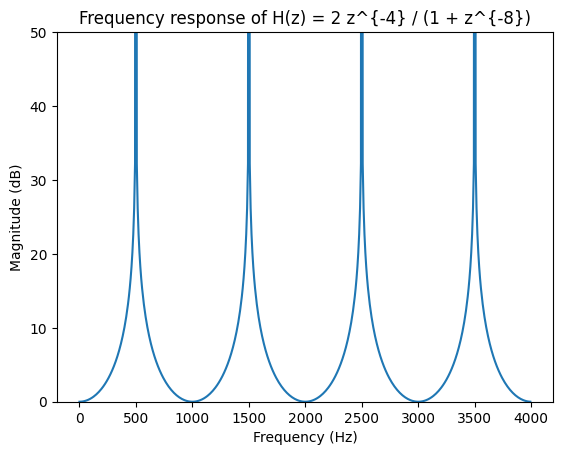

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# ============================================
# IIR フィルタ（共鳴を持つフィードバック構造）の周波数特性を可視化するコード
#
# 伝達関数 H(z) = B(z) / A(z) を
#   B(z) = 2 z^{-4}
#   A(z) = 1 + z^{-8}
# とおいたときの周波数応答 |H(e^{jω})| を plot している。
#
# ・分子 B(z) = 2 z^{-4}  → 4 サンプルの純粋な遅延（位相シフト）＋ゲイン 2
# ・分母 A(z) = 1 + z^{-8} → 8 サンプル遅延フィードバックを持つ共鳴構造
#
# A(z) の零点方程式 1 + z^{-8} = 0 から、
#   z^{-8} = -1 → z = exp(j (π + 2πk) / 8), k=0,...,7
# の位置にポールが存在し、対応する周波数で共鳴（ピーク）が現れる。
# ============================================

# サンプリングレート [Hz]
sr = 8000

# ============================================
# 1. フィルタ係数 b, a の設定
# ============================================
# 信号処理ライブラリでは一般に、
#   H(z) = (b[0] + b[1] z^{-1} + ... + b[M] z^{-M}) /
#          (a[0] + a[1] z^{-1} + ... + a[N] z^{-N})
# としてフィルタを表現する。
#
# ここでは、
#   b[4] = 2  → B(z) = 2 z^{-4}
#   a[0] = 1, a[8] = 1 → A(z) = 1 + z^{-8}
#
# となるようにゼロ配列を用意したあと、必要な位置だけ代入している。
b = np.zeros(5)  # 長さ 5 の分子係数（最大 z^{-4} まで）
a = np.zeros(9)  # 長さ 9 の分母係数（最大 z^{-8} まで）

# 分子：4 サンプル遅延のタップにゲイン 2
b[4] = 2

# 分母：z^0（現在サンプル）と z^{-8} の係数を 1 に設定
#       → A(z) = 1 + z^{-8}
a[0] = 1
a[8] = 1

# ============================================
# 2. 周波数応答の計算（signal.freqz）
# ============================================
# signal.freqz(b, a) は離散時間フィルタ H(z) の周波数応答
#   H(e^{jω}) を 0〜π [rad/sample] の範囲で計算してくれる。
#
# 戻り値：
#   - w : 正規化角周波数 [rad/sample]
#   - H : 複素周波数応答 H(e^{jω})
w, H = signal.freqz(b, a)

# ============================================
# 3. 角周波数 w を実周波数 f [Hz] に変換
# ============================================
# 離散時間の角周波数 ω [rad/sample] と実周波数 f [Hz] の関係は
#   ω = 2π f / sr
# なので、
#   f = ω sr / (2π)
# として周波数軸を Hz に変換する。
f = sr * w / (2 * np.pi)

# ============================================
# 4. 振幅スペクトル（dB）のプロット
# ============================================
# np.abs(H) : 複素周波数応答の絶対値 → 振幅スペクトル |H(e^{jω})|
# 20*log10(|H|) : dB 表示に変換（音響・信号処理で一般的な表現）
#
# A(z) = 1 + z^{-8} のポール位置に対応する周波数では、
# |H| が大きくなり、グラフ上で鋭いピークとして現れる。
plt.plot(f, 20 * np.log10(np.abs(H)))

# y 軸のスケールを 0〜50 dB に制限
# 共鳴ピークが非常に高くなりうるため、見やすい範囲にクリップしている。
plt.ylim([0, 50])

# 軸ラベルなど（任意で追加）
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Frequency response of H(z) = 2 z^{-4} / (1 + z^{-8})")

# plt.show()  # スクリプトとして実行する場合は明示的に描画

Text(0.5, 0, 'Time (s)')

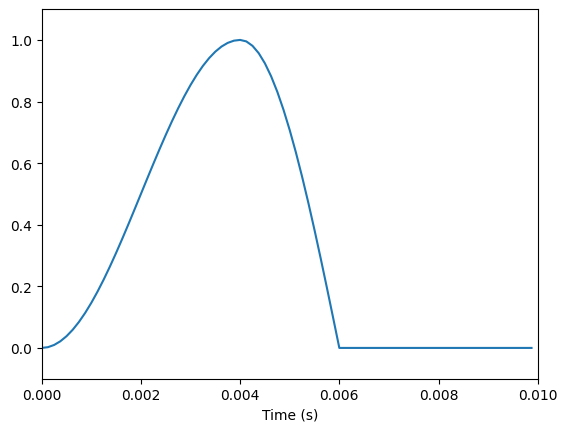

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# 疑似声門波のような「1周期分の包絡」を時間軸上に設計するコード
# - サンプリング周波数 sr = 8 kHz
# - 全長 0.01 秒（10 ms）の中で
#   * T1 = 4 ms : 立ち上がり部分（Hann 型で 0→1）
#   * T2 = 2 ms : 立ち下がり部分（cos 波で 1→0）
#   * 残り      : 0（閉鎖区間）
# という 3 区間を結合して 1 つの波形 g(t) を作っている。
# ============================================

# サンプリングレート [Hz]
sr = 8000

# 立ち上がり区間の長さ [s]
T1 = 0.004  # 4 ms

# 立ち下がり区間の長さ [s]
T2 = 0.002  # 2 ms

# ============================================
# 1. 立ち上がり区間（0〜T1）の時間軸と波形 g1
# ============================================

# t1: 0 から T1 未満まで、1/sr 間隔の時間軸
#     sr=8000 のとき 1 サンプル = 0.000125 秒なので、
#     約 32 サンプルで 0〜4 ms を表現している。
t1 = np.arange(0, T1, 1 / sr)

# g1: Hann 窓の前半に相当する形で、0 → 1 へ滑らかに立ち上がる。
#   g1(t) = 0.5 * (1 - cos(π t / T1))
# と同値であり、t=0 で g1=0、t=T1 で g1=1 になる。
# 立ち上がりを滑らかにすることで、高周波成分を抑えた包絡になる。
g1 = 0.5 * (1 - np.cos(2 * np.pi * t1 / 2 / T1))

# ============================================
# 2. 立ち下がり区間（T1〜T1+T2）の時間軸と波形 g2
# ============================================

# t2: T1 から T1+T2 未満までの時間軸（同じく 1/sr 間隔）
#     ここでは 4〜6 ms の区間を表している。
t2 = np.arange(T1, T1 + T2, 1 / sr)

# g2: cos 波を利用した 1 → 0 の減衰部分。
#   g2(t) = cos( (π/2) * (t - T1) / T2 )
# なので、
#   t = T1          のとき cos(0)     = 1
#   t = T1 + T2 のとき cos(π/2) = 0
# となり、立ち下がりが滑らかに 1→0 へ向かう。
g2 = np.cos(2 * np.pi * (t2 - T1) / 4 / T2)

# ============================================
# 3. 残り区間（T1+T2〜0.01 s）の時間軸と波形 g3
# ============================================

# t3: T1+T2 から 0.01 秒までの時間軸。
#     全体の長さを 10 ms に固定するための「閉鎖区間」に相当する。
t3 = np.arange(T1 + T2, 0.01, 1 / sr)

# g3: この区間では振幅 0（無音・閉鎖）とする。
g3 = np.zeros(t3.shape)

# ============================================
# 4. 3 区間を結合して 1 つの波形 g(t) を作成
# ============================================

# hstack で [g1, g2, g3] を連結し、0→1→0→0 の形の包絡を作る。
g = np.hstack((g1, g2, g3))

# 同様に時間軸 t も [t1, t2, t3] を結合して、g と対応を取る。
t = np.hstack((t1, t2, t3))

# ============================================
# 5. 波形のプロット
# ============================================

plt.plot(t, g)

# 全体 0〜10 ms の範囲だけを表示（それより外は存在しないが念のため）
plt.xlim([0, 0.01])

# 縦軸は -0.1〜1.1 にして、0〜1 の波形が少し余裕を持って見えるようにする。
plt.ylim([-0.1, 1.1])

plt.xlabel("Time (s)")
# plt.ylabel('Amplitude')  # 必要なら縦軸ラベルも追加

# plt.show()  # スクリプトで実行する場合は明示的に表示

Text(0.5, 1.0, 'Magnitude spectrum of glottal-like envelope g(t)')

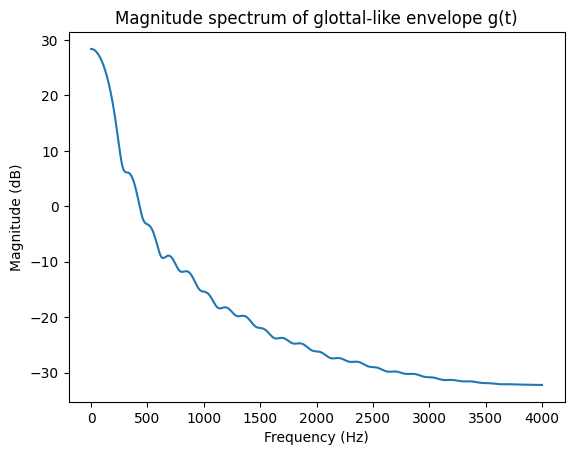

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# g(t) の周波数特性を確認するためのコード
# - 直前までに作成した 1 周期分の包絡 g（長さは 0.01 s 程度）に対して
#   実数 FFT（rFFT）を行い、振幅スペクトルを dB で描画する。
# - g は時間領域で滑らかに 0→1→0→0 と変化するパルス状の信号なので、
#   そのスペクトルは「広帯域だが高周波ほど減衰する」形になる。
# ============================================

# 既存の図を閉じてから新しいプロットを描く
plt.close()

# FFT のポイント数
# --------------------------------------------
# nFFT を g の長さ以上に取ることで、ゼロパディングによって
# 周波数軸の刻み幅を細かくできる（スペクトルの描画が滑らかになる）。
# 実際の周波数分解能自体は観測時間（ここでは約 10 ms）で決まり、
# nFFT を増やしても理論的な分解能は変わらない点に注意。
nFFT = 1024

# 実数信号 g に対して rFFT（片側スペクトル）を計算
# --------------------------------------------
# np.fft.rfft は 0〜ナイキスト周波数までの複素スペクトルを返す。
# G[k] は周波数 bin k に対応する複素振幅で、
# 振幅スペクトルは |G[k]|、位相スペクトルは arg(G[k]) となる。
G = np.fft.rfft(g, nFFT)

# 周波数軸 [Hz] の計算
# --------------------------------------------
# np.fft.rfftfreq(nFFT, 1/sr) により、
# 各 bin k が何 Hz に対応するかを計算できる。
# Δf = sr / nFFT となり、ここでは 8000 / 1024 ≒ 7.8125 Hz 間隔。
frequency = np.fft.rfftfreq(nFFT, 1 / sr)

# 振幅スペクトルの dB 表示
# --------------------------------------------
# np.abs(G) : 複素スペクトルの絶対値 → 振幅スペクトル
# 20*log10(|G|) : 振幅を dB スケールに変換
#
# 数値的には |G|=0 の bin で log10(0) → -inf になる可能性があるので、
# 実務コードでは小さな ε を足しておくと安全：
#   20*np.log10(np.abs(G) + 1e-12)
plt.plot(frequency, 20 * np.log10(np.abs(G)))

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Magnitude spectrum of glottal-like envelope g(t)")

# plt.show()  # スクリプトとして実行する場合に使用

Text(0.5, 1.0, 'Lossless vs lossy tube model frequency response')

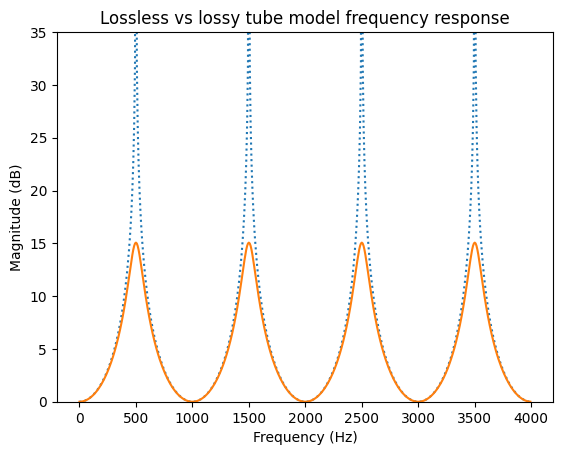

In [6]:
plt.close()

# ============================================
# 無損失・有損失の 1 次元管モデルの周波数応答を比較して描画するコード
# - どちらも z^-4, z^-8 の遅延だけからなる IIR フィルタとして実装
# - 上側のフィルタ : 理想的な「損失なし」管（反射係数の絶対値=1）
# - 下側のフィルタ : 声門・口唇でエネルギが減衰する「損失あり」管
#   → 共鳴ピークの鋭さ(Q値)やゲインの違いを可視化できる
# ============================================

nFFT = 1024  # freqz のデフォルトポイント数（ここでは特に指定しないが変数だけ用意）

# --------------------------------------------
# 1. 無損失モデル: H(z) = 2 z^{-4} / (1 + z^{-8})
# --------------------------------------------

# 分子 b: 長さ5の配列を用意し、z^-4 に相当する位置だけ 2 を立てる
#   b = [0, 0, 0, 0, 2] → B(z) = 2 z^{-4}
b = np.zeros(5)
b[4] = 2

# 分母 a: 長さ9の配列を用意し、a[0]=1, a[8]=1 とする
#   a = [1, 0, 0, 0, 0, 0, 0, 0, 1] → A(z) = 1 + z^{-8}
# これにより
#   H(z) = B(z)/A(z) = 2 z^{-4} / (1 + z^{-8})
# となる。これは反射係数 |r|=1 の理想的な閉管/開管モデルに対応し、
# 特定周波数で鋭い共鳴ピーク（フォルマント）が現れる。
a = np.zeros(9)
a[[0, 8]] = 1

# 周波数応答の計算
# w: 正規化角周波数 [rad/sample]、H: 複素周波数応答
w, H = signal.freqz(b, a)

# 周波数軸を [Hz] に変換
#   f = (sr / 2π) * w
f = sr * w / (2 * np.pi)

# 無損失モデルの振幅応答 [dB] を描画（点線）
plt.plot(f, 20 * np.log10(np.abs(H)), ":")

# --------------------------------------------
# 2. 損失モデル: H_loss(z)
#    声門側 rG, 口唇側 rL の反射係数を導入
# --------------------------------------------

# rG: 声門側の反射係数 (glottis)
# rL: 口唇側の反射係数 (lips)
#   |r| < 1 とすることで、往復ごとにエネルギが減衰するモデルになる。
rG = 0.7
rL = 1

# 損失モデルの分子・分母係数
#
# 一般に、1 次元管モデルの簡略化版では
#   H_loss(z) ≒ ((1 + rG)(1 + rL)/2) * z^{-4} / (1 + rG rL z^{-8})
# のような形が用いられる。
# ここではその係数を直接 bLoss, aLoss として与えている。
#
# 分子:
#   bLoss[4] = 0.5 * (1 + rG) * (1 + rL)
#   → B_loss(z) = 0.5 (1 + rG)(1 + rL) z^{-4}
bLoss = np.zeros(5)
bLoss[4] = 0.5 * (1 + rG) * (1 + rL)

# 分母:
#   aLoss[0] = 1, aLoss[8] = rL * rG
#   → A_loss(z) = 1 + rL rG z^{-8}
aLoss = np.zeros(9)
aLoss[0] = 1
aLoss[8] = rL * rG

# 損失モデルの周波数応答
_, HLoss = signal.freqz(bLoss, aLoss)

# 損失ありモデルの振幅応答 [dB] を描画（実線）
plt.plot(f, 20 * np.log10(np.abs(HLoss)))

# 縦軸の範囲を 0〜35 dB に制限して、ピークの違いが見やすいようにする
plt.ylim([0, 35])

plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB)")
plt.title("Lossless vs lossy tube model frequency response")

# --------------------------------------------
# 理論的な見どころ
# --------------------------------------------
# - 無損失モデル (H) はポールが単位円上にあるため、共鳴ピークが非常に鋭く、
#   理論上は無限大に近いゲインを持つ（グラフではクリップされる）。
# - 損失モデル (H_loss) では rG, rL によって |rG rL| < 1 となり、
#   ポールが単位円の内側に移動するため、共鳴ピークの高さが下がり、
#   帯域幅が広がる（Q 値が下がる）。
# - この図を見比べることで、「管内の損失や境界での反射係数」が
#   共鳴特性（フォルマントの鋭さ・ゲイン）にどう影響するかを直感的に理解できる。

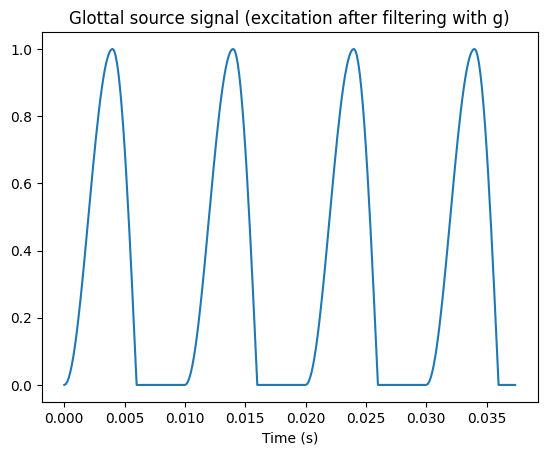

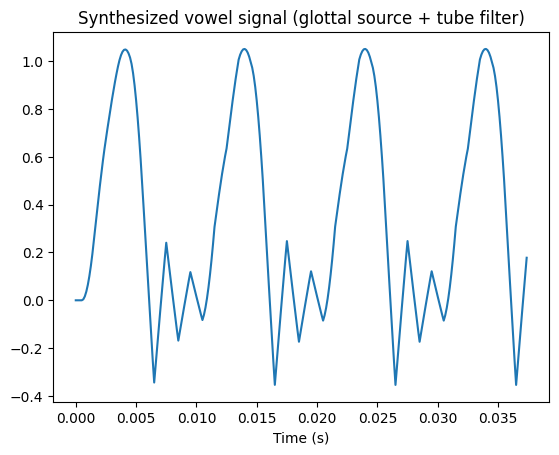

In [7]:
plt.close()

# ============================================
# 声門源パルス列 → 声門包絡 g → 声道フィルタ (bLoss, aLoss)
# を通した母音合成のデモコード
#
# 前提：
#   - g        : 1周期分の声門波「包絡」（前セルで設計した 0→1→0→0 の波形）
#   - bLoss,aLoss : 損失付き 1 次元管モデルの IIR フィルタ係数
#                   （前セルで作成した H_loss(z)）
# ============================================

sr = 8000  # サンプリング周波数 [Hz]
duration = 0.01  # 1周期の長さ [s]（= 10 ms → 100 Hz の基本周波数）

# 1周期ぶんのインパルス列（[1, 0, 0, ... 0]）を作る
nImpulse = int(np.round(duration * sr))  # 1周期あたりのサンプル数（10 ms × 8 kHz ≒ 80）
impulse = np.zeros(nImpulse)
impulse[0] = 1  # 先頭サンプルだけ 1、それ以外は 0 → ディジタルインパルス

# ============================================
# 1. 定周期インパルス列 xImpulse の生成
# ============================================

# np.matlib.repmat(impulse, 1, int(1/duration)) により、
# impulse ベクトルを横方向に繰り返して 1 秒ぶんのインパルス列を作る。
# duration=0.01 s なので int(1/duration)=100 回繰り返し → 1 秒間で 100 回のインパルス
# → 基本周波数 F0 ≒ 100 Hz の励振源になる。
xImpulse = np.matlib.repmat(impulse, 1, int(1 / duration))

# 時間軸 t（秒単位）。xImpulse は shape=(1, N) なので列数を取り出してサンプル数とする。
t = np.arange(xImpulse.shape[1]) / sr

# r は描画するサンプル範囲（ここでは先頭 300 サンプル ≒ 37.5 ms）
r = np.arange(300)

# インパルス列そのものを一度再生して、F0=100 Hz の周期を耳で確認する
IPython.display.display(IPython.display.Audio(xImpulse, rate=sr))

# ============================================
# 2. 声門包絡 g との畳み込み（FIR フィルタによる声門源生成）
# ============================================

# signal.lfilter(g, 1, xImpulse) は、
#   yGlottal = g * xImpulse （* は離散畳み込み）
# に対応する。
# つまり「インパルス列」を「単一周期の声門波形 g で畳み込む」ことで、
# 各インパルス位置に g を貼り付けた定常的な声門波列を作っている。
yGlottal = signal.lfilter(g, 1, xImpulse)

# 先頭 300 サンプルの波形をプロットして、
# 「周期 10 ms のベル型パルス列」になっていることを可視化
plt.plot(t[r], yGlottal[0, r])
plt.xlabel("Time (s)")
plt.title("Glottal source signal (excitation after filtering with g)")

# 声門波列を再生して、インパルス列よりも高域が抑えられた「声帯振動っぽい音」を確認
IPython.display.display(IPython.display.Audio(yGlottal, rate=sr))

# ============================================
# 3. 声道フィルタ (bLoss, aLoss) との畳み込み → 母音波形 yVowel
# ============================================

# 損失付き管モデル H_loss(z) = B_loss(z)/A_loss(z) を使って、
# yGlottal をフィルタリングすることで母音っぽい音声を合成する。
#
# 数式的には：
#   yVowel[n] = Σ_k bLoss[k] * yGlottal[n-k] - Σ_m aLoss[m] * yVowel[n-m]
# となり、声門源を声道共鳴器へ通す「source–filter モデル」の実装になっている。
yVowel = signal.lfilter(bLoss, aLoss, yGlottal)

# 再び先頭 300 サンプルの波形を描画。
# g による包絡＋管共鳴の両方が重なった、より「音声波形らしい」形になる。
plt.figure()
plt.plot(t[r], yVowel[0, r])
plt.xlabel("Time (s)")
plt.title("Synthesized vowel signal (glottal source + tube filter)")

# 合成された母音波形を再生して、共鳴（フォルマント）による音色変化を耳で確認
IPython.display.display(IPython.display.Audio(yVowel, rate=sr))

In [8]:
# サンプリング周波数 [Hz]
# ここでは 8 kHz サンプリングを前提に、後でフォルマント周波数 [Hz] に変換するために使う
sr = 8000

# ============================================
# 1. 2 管モデル（上下 2 セクション）の境界条件パラメータ
# ============================================

# rG, rL:
#   - rG: 声門側（glottis 側）の反射係数
#   - rL: 口唇側（lips 側）の反射係数
#   |r| < 1 なら損失あり、|r| = 1 なら完全反射を表す
rG = 1  # 声門側は完全反射と仮定
rL = 0.7  # 口唇側はやや損失あり

# a1a2:
#   2 つの管セクションの断面積を A1, A2 としたときの比 A1/A2 を a1a2 としているイメージ
#   （ここでは A1/A2 ≒ 1/7 として、細い→太い 2 セクションを表現）
a1a2 = 1 / 7

# L1L2:
#   2 セクションの長さ比 L1/L2 を表すパラメータ（ここでは 1 で同じ長さと仮定）
L1L2 = 1

# r1:
#   セクション 1 と 2 の境界における反射係数
#   一般に音響インピーダンス Z ∝ 1/A とみなすと、
#   インピーダンスの不連続による反射係数は
#       r = (Z2 - Z1) / (Z2 + Z1)
#   A 比で書き直すと
#       r = (1 - A1/A2) / (1 + A1/A2)
#   の形になる。ここでは a1a2 = A1/A2 として r1 を計算している。
r1 = (1 - a1a2) / (1 + a1a2)

# ============================================
# 2. 2 セクション管モデルの分母多項式 aA(z) の構成
# ============================================

# aA は 2 セクション管モデルから導かれる all-pole フィルタの分母係数
#   A(z) = 1 + aA[4] z^{-4} + aA[8] z^{-8}
# のような形になっている（長さは 9 要素で 0〜8 次を表現）。
aA = np.zeros(9)

# z^0 の係数 → 常に 1（正規化された all-pole フィルタ）
aA[0] = 1

# z^{-4} の係数:
#   - r1 (セクション境界の反射)
#   - rG + rL（声門側と口唇側の境界条件の寄与）
#   の積として与えられている。
#   これは「1 往復（2 セクション分）」の途中での反射の組み合わせを
#   まとめて表した項とみなせる。
aA[4] = r1 * (rG + rL)

# z^{-8} の係数:
#   - rL * rG
#   声門側と口唇側の反射が 1 往復して戻ってくる過程を表しており、
#   「1 往復ぶんの総合反射係数」に相当する。
aA[8] = rL * rG

# ここで得られる A(z) は 2 セクション管（同長 L1=L2）を
# 離散時間フィルタとして表現した all-pole モデルになっており、
# その極（ポール）の角周波数がフォルマント周波数に対応する。

# ============================================
# 3. 極（ポール）の角度からフォルマント周波数を計算
# ============================================

# np.roots(aA):
#   分母多項式 A(z) の根（極）を複素数として求める。
#   単位円近傍にある共役複素根の角度が共鳴周波数（フォルマント）になる。
# np.angle(...):
#   各極の偏角（-π〜π）を求める。
# 割り算 /2/np.pi*sr:
#   角度 θ [rad] を周波数 [Hz] に変換する式
#       f = θ / (2π) * sr
#   をベクトル演算で適用している。
formant = np.angle(np.roots(aA)) / (2 * np.pi) * sr

# 正の周波数成分だけを取り出し、昇順にソートして「フォルマント候補」を得る。
# 実際には、その中から音声帯域内 (〜4000 Hz) のものを
# 第1フォルマント F1, 第2フォルマント F2 ... として解釈していく。
np.sort(formant[formant > 0])

array([ 775.761874, 1224.238126, 2775.761874, 3224.238126])

Text(0, 0.5, 'log |SA(f)|')

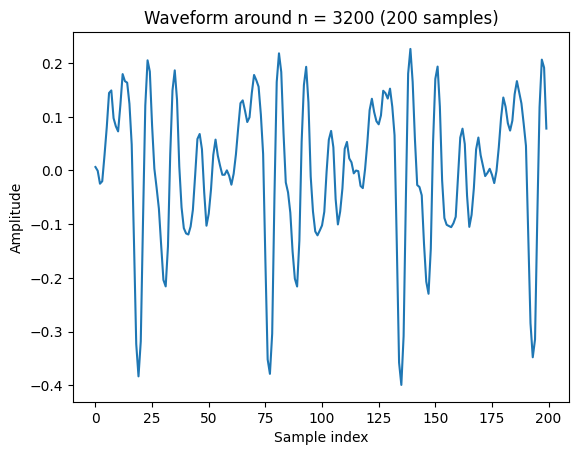

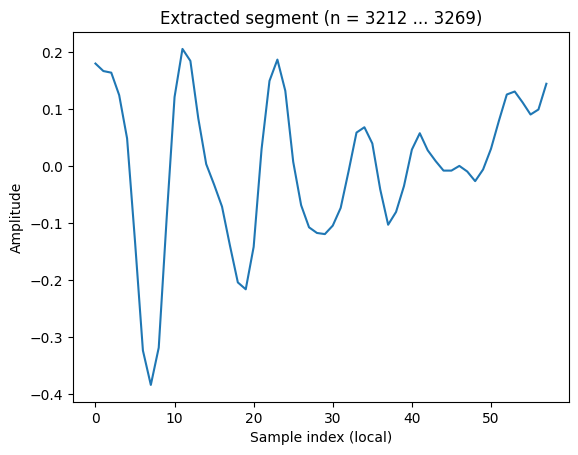

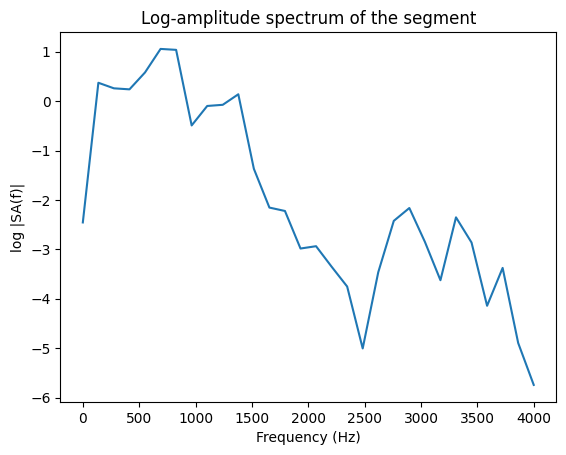

In [10]:
# 以前のプロットを閉じて図が重ならないようにする
plt.close()

# ----------------------------------------------------
# 1. /sa/ 音声の読み込みと時間波形の一部プロット
# ----------------------------------------------------
# 'sa48k.wav' をサンプリング周波数 8 kHz にリサンプリングして読み込む
#   ySa : 音声波形（1 次元 numpy 配列）
#   sr  : 実際に読み込まれたサンプリング周波数（ここでは 8000 Hz になる想定）
ySa, sr = librosa.load("sa48k.wav", sr=8000)

# 時間 3200 サンプル目から 200 サンプル分を取り出してプロット
#   3200 サンプル / 8000 Hz ≒ 0.4 s 以降のごく一部の区間を見ている
#   サンプル数 200 → 約 25 ms の区間
plt.plot(ySa[3200 + np.arange(200)])
plt.title("Waveform around n = 3200 (200 samples)")
plt.xlabel("Sample index")
plt.ylabel("Amplitude")

# ----------------------------------------------------
# 2. スペクトル解析対象の短いセグメントの抽出
# ----------------------------------------------------
# さらに、その中から 3200+12 〜 3200+69 サンプルを切り出す
#   12〜69 → 58 サンプル（len(segment) = 58）
#   58 / 8000 ≒ 7.25 ms 程度の非常に短い時間窓
#   /sa/ の中の一瞬の音声フレームとして扱うイメージ
segment = ySa[3200 + np.arange(12, 70)]

# 抽出した短いセグメントの波形を別の Figure で表示
plt.figure()
plt.plot(segment)
plt.title("Extracted segment (n = 3212 ... 3269)")
plt.xlabel("Sample index (local)")
plt.ylabel("Amplitude")

# ----------------------------------------------------
# 3. セグメントのフーリエ変換（スペクトルの計算）
# ----------------------------------------------------
# 離散フーリエ変換（DFT）の実数対称版 rFFT を計算
#   SA : segment の複素スペクトル（片側スペクトル）
#       周波数ごとに「振幅」と「位相」の情報を持つ
SA = np.fft.rfft(segment)

# rfftfreq で対応する周波数軸 [Hz] を計算
#   len(segment) : DFT のポイント数（ここでは 58 ポイント）
#   1/sr         : サンプリング周期（秒）
#   → 周波数解像度は sr / len(segment) [Hz]
frequency = np.fft.rfftfreq(len(segment), 1 / sr)

# ----------------------------------------------------
# 4. 振幅スペクトル（対数スケール）のプロット
# ----------------------------------------------------
plt.figure()
# np.abs(SA) : 振幅スペクトル |SA(f)| を取り出す
# np.log(...) : 対数をとることで、ダイナミックレンジの広いスペクトルを見やすくする
#   （本来は log10 を使って dB にすることも多いが、ここでは自然対数）
plt.plot(frequency, np.log(np.abs(SA)))
plt.title("Log-amplitude spectrum of the segment")
plt.xlabel("Frequency (Hz)")
plt.ylabel("log |SA(f)|")

# ここまでで、
# - /sa/ 音声の一部を時間領域で観察し
# - さらに短いセグメントに切り出して
# - そのセグメントの周波数成分（スペクトル）を可視化
# という一連の「短時間スペクトル解析」の流れを確認できる。

In [11]:
# 2 セクション管（two-tube）モデルの周波数応答を計算する関数
# ------------------------------------------------------------------
# f      : 周波数 [Hz]（スカラーでも配列でもよい想定）
# rL     : 口唇側（lips）の反射係数
# rG     : 声門側（glottis）の反射係数
# r1     : セクション 1 と 2 の境界（断面積の変化部）の反射係数
# L      : 全管長 [m]（L1 + L2 を想定）
# c      : 音速 [m/s]
# L1L2   : セクション長の比 L1/L2（L1 = L1L2/(L1L2+1) * L という解釈）
#
# 戻り値:
#   H(f) : 2-tube 声道モデルの周波数応答（複素数）
#
# 理論的には、1 次元音響管の伝搬を
#   - 各境界での反射（rG, rL, r1）
#   - 管内の伝搬位相 exp(-j k l) （k = 2π f / c）
# に分解し、全往復経路のうち有力なものを 3 本の項として足し合わせた
# all-pole 型の周波数応答を記述している。
#
# 分子:
#   0.5 * (1 + rG) * (1 + rL) * r1 * exp(-j 2π f L / c)
#   → 声門・口唇両端での透過係数 (1 + r)/2 と中間境界 r1 をまとめた係数
#     ＋ 全体の位相遅延 exp(-j ω L / c) を掛けている
#
# 分母:
#   1
#   + r1 rG exp(-j 2π f * (2 L1))  （声門側から 2 セクション 1 を往復する経路）
#   + r1 rL exp(-j 2π f * (2 L2))  （口唇側から 2 セクション 2 を往復する経路）
#   + rL rG exp(-j 2π f * (2 L ))  （管全体 L を 1 往復する経路）
#
# ここでは L1, L2 を L と比率 L1L2 から
#   L1 = (L1L2 / (L1L2 + 1)) * L
#   L2 = (1 / (L1L2 + 1)) * L
# とみなし、その 2L1, 2L2, 2L を位相項の中に反映している。
#
# 結果として、H(f) の極の位置が 2-tube モデルのフォルマント周波数
# （第 1, 第 2 フォルマントなど）に対応する。
def freqz_two_tube(f, rL, rG, r1, L, c, L1L2):
    return (
        0.5
        * (1 + rG)
        * (1 + rL)
        * (1 * r1)
        * np.exp(-2j * np.pi * f * L / c)
        / (
            1
            + r1
            * rG
            * np.exp(-2j * np.pi * f * 2 * L1L2 / (L1L2 + 1) * L / c)  # セクション1往復
            + r1
            * rL
            * np.exp(-2j * np.pi * f * 2 / (1 + L1L2) * L / c)  # セクション2往復
            + rL * rG * np.exp(-2j * np.pi * f * 2 * L / c)
        )
    )  # 全長往復

In [12]:
# ============================================
# 2管モデル（two-tube）＋声門源による /a/ 合成
# ============================================

# 声門側と口唇側の反射係数
# rG : glottis（声門）側の反射係数
# rL : lips（口唇）側の反射係数
# ここでは rG = 1（完全反射）, rL = 0.7（やや損失あり）と仮定
rG = 1
rL = 0.7

# a1a2 : 断面積比 A1/A2
#   - A1 : 喉側の管断面積
#   - A2 : 口側の管断面積
# ここでは a1a2 = 27/73 としており、A1 < A2 の細→太構造を表現している。
a1a2 = 27 / 73

# L1L2 : 長さ比 L1/L2
#   - L1 : 喉側の管長
#   - L2 : 口側の管長
# L1L2 = 7/9 → L1 : L2 = 7 : 9 という 2 セクション構造
L1L2 = 7 / 9

# L : 全管長 [m]
# c : 音速 [m/s]
#   ここでは L = 0.17 m（およそ 17 cm）、c = 340 m/s として、
#   成人の平均的な声道長＋空気中の音速に近い値を使っている。
L = 0.17
c = 340

# r1 : セクション境界（A1 と A2 の境界）の反射係数
# 一般に、断面積比 A1/A2 = a1a2 に対する反射係数は
#   r1 = (1 - a1a2) / (1 + a1a2)
# と表わせる（音響インピーダンス Z ∝ 1/A としたときの反射係数）。
r1 = (1 - a1a2) / (1 + a1a2)

# ------------------------------------------------
# 1. 2管モデルの周波数応答 Va(f) の計算
# ------------------------------------------------

# f : 周波数軸 [Hz]（0〜ナイキスト周波数まで）
#   int(fs/2)+1 個の周波数点を用意して、rFFT との対応を取る。
#   fs はサンプリング周波数（通常は sr = 8000 と同じ値）を想定している。
f = np.arange(int(fs / 2) + 1)

# Va : two-tube 声道モデルの周波数応答 H(f)
#   freqz_two_tube 内で
#   - 各境界の反射 rG, rL, r1
#   - 各セクション長 L1, L2 に応じた位相 exp(-j 2π f L/c)
# を用いて、2 セクション構造の全体伝達特性を計算している。
Va = freqz_two_tube(f, rL, rG, r1, L, c, L1L2)

# ------------------------------------------------
# 2. 声門源スペクトル SGlottal(f) の計算
# ------------------------------------------------

# yGlottal[0, :] :
#   以前に作成した「声門源波形」（インパルス列を g でフィルタした信号）
#   shape = (1, N) を想定しており、その 0 行目を取り出して 1 次元信号として扱う。
#
# np.fft.rfft(...) :
#   実信号 yGlottal から片側スペクトル（0〜ナイキスト）を計算する。
#   これがソーススペクトル G(f) に相当する。
SGlottal = np.fft.rfft(yGlottal[0, :])

# ------------------------------------------------
# 3. 声門源スペクトル × 声道フィルタ = 母音スペクトル
# ------------------------------------------------

# SA : /a/ のスペクトル（Vowel A の意味だと思われる）
#   SA(f) = G(f) * H(f) = SGlottal(f) * Va(f)
#   という「source–filter モデル」の基本式をそのまま実装している。
SA = SGlottal * Va

# ------------------------------------------------
# 4. IFFT による時間波形 yA の復元と再生
# ------------------------------------------------

# np.fft.irfft(SA) :
#   片側スペクトル SA から、実数の時間波形 yA[n] を再構成する。
#   これが two-tube モデルを通した /a/ の合成音声になる。
yA = np.fft.irfft(SA)

# IPython.display.Audio:
#   合成結果 yA を音声として再生。
#   rate=sr とすることで、元のサンプリング周波数（例: 8000 Hz）で再生される。
IPython.display.Audio(yA, rate=sr)